# Лабораторная работа №1

In [1]:
# !pip install pandas
# !pip install trimesh
# !pip install scipy
# !pip install matplotlib

In [2]:
import numpy as np
import math
import trimesh

# attach to logger so trimesh messages will be printed to console
#trimesh.util.attach_to_log()

# some formats represent multiple meshes with multiple instances
# the loader tries to return the datatype which makes the most sense
# which will for scene-like files will return a `trimesh.Scene` object.
# if you *always* want a straight `trimesh.Trimesh` you can ask the
# loader to "force" the result into a mesh through concatenation
mesh = trimesh.load('models/!EXPORT_Isaac_3DML.stl') #, force='mesh')

## POLYGON MESH

In [3]:
angle = math.pi / 2
direction = [-1, 0, 0]
center = [0, 0, 0]

rot_matrix = trimesh.transformations.rotation_matrix(angle, direction, center)

# transform method can be passed a (4, 4) matrix and will cleanly apply the transform
mesh.apply_transform(rot_matrix)

# preview mesh in an opengl window if you installed pyglet and scipy with pip
mesh.show()

## VOXEL

In [4]:
voxel_mesh = mesh.voxelized(0.1) 
voxel_mesh.show()

## POINT CLOUD

In [5]:
points_mesh = trimesh.convex.hull_points(mesh)

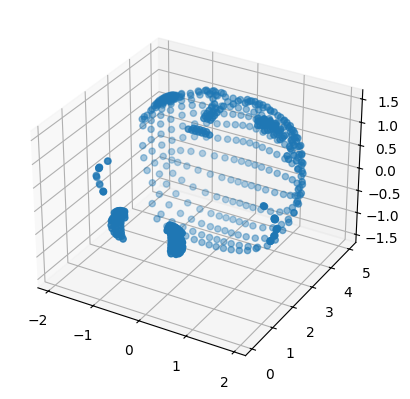

In [6]:
trimesh.points.plot_points(points_mesh, show=True)

## FUNCTION

In [7]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117.
# torch.cuda.is_available()

In [8]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

In [9]:
# !pip install mesh-to-sdf
# !pip install scikit-learn
import mesh_to_sdf
center_mass = mesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])
for point in query_points:
    print(
        "SDF{0} = {1}".format(point[0],mesh_to_sdf.mesh_to_sdf(mesh,point)[0])
)

SDF[2.98032415e-17 3.27906317e+00 6.27487771e-02] = -0.6143748760223389
SDF[3. 3. 3.] = 2.474323272705078


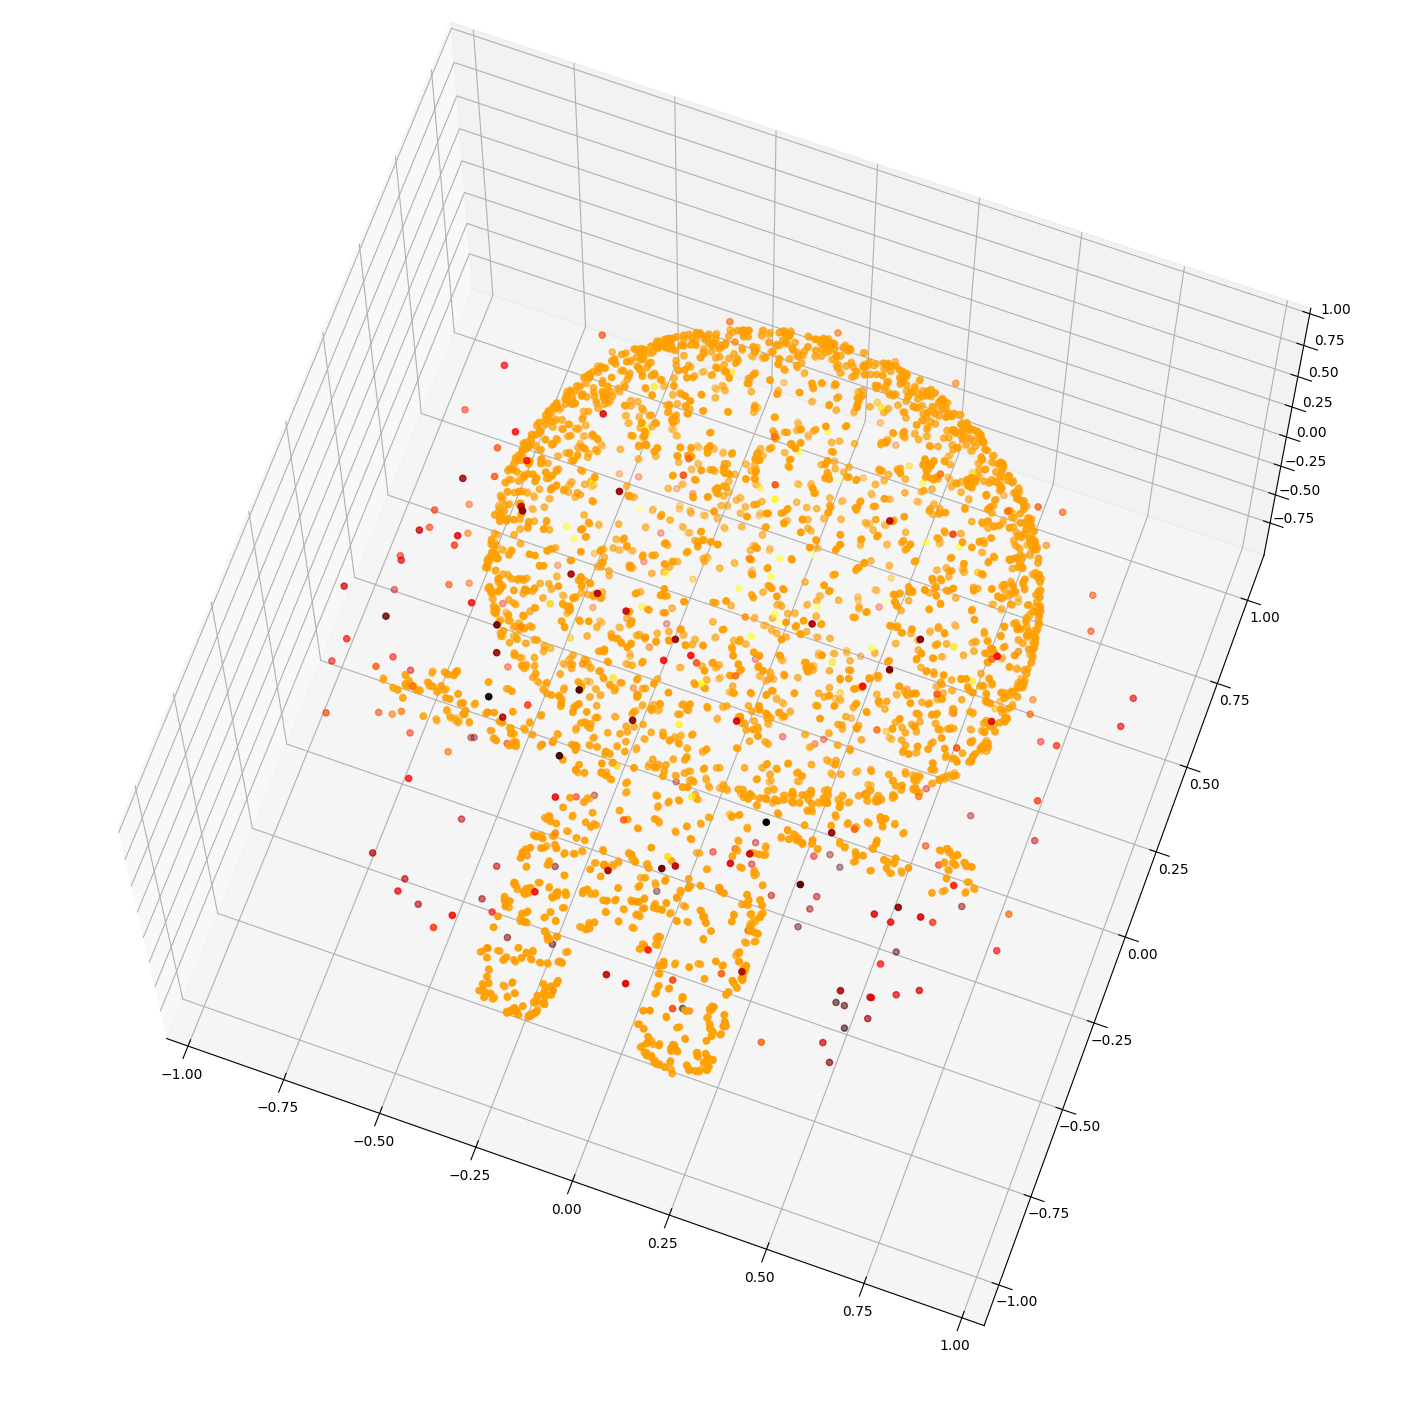

In [10]:
import matplotlib.pyplot as plt
points, sdf = mesh_to_sdf.sample_sdf_near_surface(mesh, number_of_points=5000)
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")

## DEPTH (2,5D)

## Deform a source mesh to form a target mesh using 3D loss functions

In [11]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

### 1. Load an obj file and create a Meshes object

In [12]:
trg_obj = 'models/!EXPORT_Isaac_3DML.obj'

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

### 2. Visualize the source and target meshes

In [13]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [14]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3. Optimization loop 

In [15]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [16]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [17]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()


  0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [18]:
#!pip install jupyter
#!pip install --upgrade jupyter
#!pip install --upgrade ipywidgets
# !pip install notebook==6.1.5
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable varInspector/main

### 4. Visualize the loss

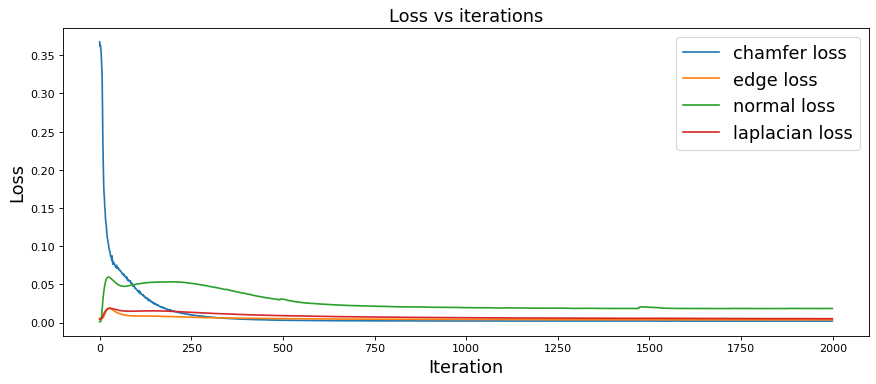

In [19]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

### 5. Save the predicted mesh

In [20]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = 'models/final_model.obj'
save_obj(final_obj, final_verts, final_faces)

In [21]:
result = trimesh.load('models/final_model.obj')

angle = math.pi / 2
direction = [-1, 0, 0]
center = [0, 0, 0]

rot_matrix = trimesh.transformations.rotation_matrix(angle, direction, center)

# transform method can be passed a (4, 4) matrix and will cleanly apply the transform
result.apply_transform(rot_matrix)

# preview mesh in an opengl window if you installed pyglet and scipy with pip
result.show()